<a href="https://colab.research.google.com/github/fabriciosantana/nlp/blob/main/AKCIT_NLP_M7_Colab_Unidade_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Objetivo:

*  Neste notebook iremos ver como uma RNN e LSTM podem ser implementadas em um problema de classificação de texto. Iremos explorar suas qualidades e defeitos a partir de um conjunto de dados real.

## 2 - Organização do ambiente

Primeiro iremos instalar um pacote usado para baixar conjuntos de dados do site HuggingFace.
Após instalação e necessário reiniciar o ambiente

In [ ]:
!pip install datasets keras==2.15.0 tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uni

Neste notebook usaremos o [Keras](https://keras.io/about/), que é uma biblioteca integrada ao Tensorflow ou Pytorch e que nos permite implementar novas redes neurais de forma bastante simplificada.

Seu uso é principalmente recomendado para prototipação de novas arquiteturas.

### 3 - Imports
Para iniciar vamos importar as bibliotecas que iremos usar no notebook
- NLTK: Vamos usar o tokenizador de texto da biblioteca chamado punkt
- Keras: Implementar a rede recorrente
- gensim: Carregar Word2Vec

Por fim vamos definir o seed do keras. Seed é uma forma de controlar as funções aletórias. Como ao criar uma nova rede neural ele é iniciada com pesos aleatórios o seed fixo vai garantir que todas as vezes que executarmos o notebook teremos o mesmo ponto de partida.

In [ ]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import string
import pandas as pd

from gensim.models import *

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors

# Define a seed para garantir o mesmo resultado a cada execução
keras.utils.set_random_seed(812)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 4 - Word2Vec

Aqui faremos o download do Word2Vec treinado em português.

Os *embeddings* foram treinados pelo NILC (Núcleo Interinstitucional de Linguística Computacional do ICMC - USP) em um conjunto de diversos textos em português e também estão disponíveis no [link](http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc).

No bloco de código abaixo é feito o *download*, extração do arquivo zip e carregamento dos *embeddings* usando a biblioteca gensim.

In [ ]:
# Download do arquivo
!wget -O "w2v.zip" "http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s100.zip"
# Extração do zip
!unzip "w2v.zip"
# Aqui os pesos são carregado com a biblioteca gensim
word2vec = KeyedVectors.load_word2vec_format("skip_s100.txt")

# Definição do tamando dos embeddings. É necessário manter apenas 100 dimensões pois o arquivo baixado possui 100 dimensões
EMB_DIM = 100

--2024-08-20 12:22:32--  http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s100.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337179242 (322M) [application/octet-stream]
Saving to: ‘w2v.zip’

w2v.zip             100%[===================>] 321.56M  11.2MB/s    in 30s     

2024-08-20 12:23:02 (10.7 MB/s) - ‘w2v.zip’ saved [337179242/337179242]

Archive:  w2v.zip
  inflating: skip_s100.txt           


## 5 - Dataset - [HateBR - Offensive Language and Hate Speech Dataset in Brazilian Portuguese](https://huggingface.co/datasets/ruanchaves/hatebr)

Como conjunto de dados iremos usar um *dataset* brasileiro de classificação de discurso de ódio. O *dataset* está disponível abertamente e inclui 7000 exemplos anotados extraídos da rede social Twitter(atual X).

Aqui é feito o *download* dos 2 arquivos principais, conjunto de treino e de teste.

In [ ]:
train_dataset, test_dataset = datasets.load_dataset("ruanchaves/hatebr", split=["train", "test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4480 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1400 [00:00<?, ? examples/s]

O dataset possui a variável 'instagram_comments' contendo o texto, 'offensive_language' com o rótulo sobre ser ou não conteúdo ofensivo.
As outras variáveis são rótulos mais espeçificos, como 'offensiveness_levels' que indica o nível de ofensa, e categorias de ofensas como 'homophobia', 'racism', e 'sexsim'

Iremos usar nessa demonstração apenas o rótulo principal que indica linguagem ofensiva ou não.

In [ ]:
pd.DataFrame(train_dataset)

## 6 - Pré-processamento

Para preparar os dados para o treino é feito um pré-processamento simples.

- Conversão dos textos para caixa baixa.
- Remoção da pontuação.
- Tokenização convertendo em uma lista de palavras.



In [ ]:
train_data = []
test_data = []

# Trata conjunto de treino
for data in train_dataset:
  # Separa entrada (text) do rótulo (y) com base na variável 'offensive_language'
  text = data['instagram_comments']
  y = data['offensive_language']

  # Transforma em caixa baixa
  s = str(text).lower()

  # Remove pontuação
  table = str.maketrans({key: None for key in string.punctuation.replace("'", "")})
  s = s.translate(table)
  s = s.translate(str.maketrans({"'" : " "}))

  # Adiciona ao vetor de entradas tratadas
  train_data.append([s, y])

# Trata conjunto de teste
for data in test_dataset:
  # Separa entrada (text) do rótulo (y)
  text = data['instagram_comments']
  y = data['offensive_language']

  # Transforma em caixa baixa
  s = str(text).lower()

  # Remove pontuação
  table = str.maketrans({key: None for key in string.punctuation.replace("'", "")})
  s = s.translate(table)
  s = s.translate(str.maketrans({"'" : " "}))

  # Adiciona ao vetor de entradas tratadas
  test_data.append([s, y])

# Transforma os vetores em DataFrames
train_data = pd.DataFrame(train_data, columns=['input', 'label'])
test_data = pd.DataFrame(test_data, columns=['input', 'label'])

# Aplica o tokenizador nas entradas (input)
train_data['input'] = train_data['input'].apply(lambda x: word_tokenize(x))
test_data['input'] = test_data['input'].apply(lambda x: word_tokenize(x))

Podemos visualizar o dataframe com os dados já pré-processados em amostras. A coluna *input* possui a lista de tokens, ainda em linguagem natural, e a coluna *label* armazena a resposta de cada amostra em um tipo lógico.

In [ ]:
train_data.head()

,input,label
0,"[este, lixo]",True
1,"[comunista, safada]",True
2,"[comunista, lixo]",True
3,[esquerdista],True
4,"[oportunista, essa, corruptaagora, todos, os, ...",True


## 7 - Preparo dos dados

Agora precisamos converter as palavras em identificadores inteiros, pois as bibliotecas de redes neurais possuem implementadas camadas que fazem o mapeamento dos *embeddings* a partir de inteiros. Essa formatação torna o código mais eficiente pois representamos a palavra da menor forma possível e apenas no momento do *feedfoward* da rede que ela será substítuida por um vetor denso como o de um Word2Vec.

In [ ]:
# Identifica todas as palavras únicas do dataset de treino
all_training_words = [word for tokens in train_data["input"] for word in tokens]
TRAINING_VOCAB = sorted(list(set(all_training_words)))

In [ ]:
# Definir o tamanho máximo das sentenças
MAX_LEN = 30

# Aqui iremos ensinar o Tokenizer a mapear as palavras do dataset para que ele aprenda a quebrar as palavras em tokens
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(train_data["input"].tolist())

# Aqui convertemos o conjunto de treino e teste para inteiros
training_sequences = tokenizer.texts_to_sequences(train_data["input"].tolist())
test_sequences = tokenizer.texts_to_sequences(test_data["input"].tolist())

# Por fim vamos fazer o padding que é o processo de adicionar 0s na frase para torna todas em uma lista do mesmo tamanho.
# A referência usada é o MAX_LEN, frases maiores que MAX_LEN são cortadas e assim terão no máximo 30 tokens, enquanto frases menores também ficaram com 30 por conta do padding.
train_hate_data = pad_sequences(training_sequences, maxlen=MAX_LEN)
test_hate_data = pad_sequences(test_sequences, maxlen=MAX_LEN)

# Agora precisamos ver qual inteiro está sendo usado para cada palavra e  usar isto para ajustar o mapeamento do Word2vec
train_word_index = tokenizer.word_index
print('Número de palavras únicas %s.' % len(train_word_index))

Número de palavras únicas 9221.


Após definir o mapeamento das palavras precisamos criar a matriz de pesos a partir do Word2Vec treinado. Para isso vamos pegar cada uma das palavras do vocabulário e usar o objeto do Word2Vec para identificar o vetor denso que a representa.

Caso a palavra não tenha vetor referente será adicionado um vetor aleatório. Isso é necessário porque o *dataset* possui alguns emojis, neologismos e termos usados no Twitter conforme exemplos apresentados pelo *print*.

In [ ]:
# Cria matriz numpy para receber os pesos com base no total de palavras no dicionário e tamanho dos embeddings (dicionario, embs)
train_embedding_weights = np.zeros((len(train_word_index)+1, EMB_DIM))

# Para cada palavra no dicionário pega o vetor correspondente
for word,index in train_word_index.items():
  if word in word2vec:
    # Se houver vetor pré-treinado o capturamos do objeto word2vec
    train_embedding_weights[index,:] = word2vec[word]
  else:
    # Aqui é para caso a palavra não existe nos vetores pré-treinados. isso ocorre com neologismos e emojis
    if(index < 500):
      # Dentre as 500 primeiras palavras avaliadas imprimimos as inexistentes para demonstração
      print("Palavra não encontrada: ", word)

    # Caso não tenhamos vetor pré-treinado será usado um vetor aleatório
    train_embedding_weights[index,:] = np.random.rand(EMB_DIM)
print(train_embedding_weights.shape)

Palavra não encontrada:  joicehasselmannoficial
Palavra não encontrada:  globolixo
Palavra não encontrada:  “
Palavra não encontrada:  ”
Palavra não encontrada:  à
Palavra não encontrada:  👏👏👏
Palavra não encontrada:  👏👏👏👏
Palavra não encontrada:  🇧🇷
Palavra não encontrada:  😂😂😂
Palavra não encontrada:  2022
Palavra não encontrada:  👏👏
Palavra não encontrada:  🤮
Palavra não encontrada:  👏👏👏👏👏
Palavra não encontrada:  bolsonarosp
(9222, 100)


Checando o *dataset* podemos ver os estágios de pré-processamento. Inicialmente a lista de tokens conhecidos, depois uma sequência de identificadores dos tokens e por fim uma sequência de inteiros com comprimento fixo.

In [ ]:
train_data["input"][0]

['este', 'lixo']

In [ ]:
training_sequences[0]

[98, 80]

In [ ]:
train_hate_data[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 98, 80], dtype=int32)

## 8 - RNN

Agora iremos implementar um modelo de RNN simples usando o Keras.

Neste modelo temos:
- Uma camada *Embedding* que é usada para receber a matriz dos vetores do Word2Vec;
- Uma camada *Simple*RNN que é uma RNN de Elman simples com estado interno *h* de tamanho 8;
- Uma camada Dense com um neurônio que irá pegar o estado interno final após ler a sentença e irá responder um valor entre 0 e 1 para classificar a sentença.
O Modelo é compilado e será otimizado usando a entropia cruzada como função de erro e acurácia como métrica a ser acompanhada.

Documentação do Keras:
- [Modelo Sequential](https://keras.io/guides/sequential_model/)
- [Camadas disponíveis](https://keras.io/api/layers/)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

# O objeto Sequential do keras permite alinhar uma sequência de camadas que são incluídas com o método .add()
# Link para documentação do modelo Sequential: keras.io/guides/sequential_model/
model = Sequential()
# Aqui adicionamos uma camada Embedding. Ela irá transformar índices (como 1, 34 ou 182) em vetores densos.
model.add(Embedding(input_dim=len(train_word_index)+1,  # Total de palavras únicas
                    output_dim=EMB_DIM,                 # Dimensões do vetor
                    input_length=MAX_LEN,               # Tamanho máximo
                    weights=[train_embedding_weights],  # Pesos para inicialização (matriz que baixamos do word2vec treinado)
                    trainable=False))                   # Define se a camada será treinada junto com a rede.
                                                        # Aqui definimos falso para manter a representação incial, mas é interessante também permitir que seja retreinada

model.add(SimpleRNN(8))                                 # Adicionamos uma camada de RNN simples com estado h de tamanho 8
model.add(Dense(1, activation='sigmoid'))               # Uma camada Dense, que é uma camada de MLP, com saída 1.
                                                        # No Keras não definimos o número de entradas porque ele irá pegar automáticamente que a camada anterior tem 8 saídas e irá construir os 8 pesos para tratar as entradas

# Aqui o modelo é compilado. Isso significa pegar as específicações e construir os pesos.
# No momento de compilar definimos o otimizador (adam), a função de perda (entropia cruzada para problemas binários, uma função bem comum e muito eficiente) e a métrica a ser acompanhada (acurácia)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Aqui executamos o treino do modelo com 10 épocas e *batch* de 32 sentenças. O treino possui o processo de validação feito com 20% das sentenças de treino que serão separadas para teste a cada época.

- Época é o nome que damos a uma volta inteira pelo conjunto de dados. Dessa forma, 10 épocas significam que cada exemplo, ao fim, será usado 10 vezes para ajustar a rede.

- *Batchs* são lotes de dados. Ao invés de usarmos o *dataset* todo, nós processamos 32 exemplos, calculamos o erro e já fazemos o ajuste dos pesos com o *backpropagation* e a resposta do *batch*.


 **Exercício 1**: Tente alterar os parâmetros de *batch* e épocas para ver o comportamento do treinamento mudar.

In [ ]:
model.fit(train_hate_data, train_data['label'], epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
112/112 [==============================] - 6s 30ms/step - loss: 0.6564 - accuracy: 0.6138 - val_loss: 0.8921 - val_accuracy: 0.3471
Epoch 2/10
112/112 [==============================] - 3s 30ms/step - loss: 0.5705 - accuracy: 0.7104 - val_loss: 0.9703 - val_accuracy: 0.3248
Epoch 3/10
112/112 [==============================] - 3s 24ms/step - loss: 0.5042 - accuracy: 0.7598 - val_loss: 1.0057 - val_accuracy: 0.3739
Epoch 4/10
112/112 [==============================] - 2s 17ms/step - loss: 0.4604 - accuracy: 0.7927 - val_loss: 0.8647 - val_accuracy: 0.5424
Epoch 5/10
112/112 [==============================] - 2s 16ms/step - loss: 0.4333 - accuracy: 0.8069 - val_loss: 1.0125 - val_accuracy: 0.5011
Epoch 6/10
112/112 [==============================] - 2s 16ms/step - loss: 0.4188 - accuracy: 0.8167 - val_loss: 0.9294 - val_accuracy: 0.5424
Epoch 7/10
112/112 [==============================] - 2s 15ms/step - loss: 0.4090 - accuracy: 0.8287 - val_loss: 1.0386 - val_accuracy: 0.4844

Ao fim podemos ver o erro do modelo (loss) e seu desempenho.

Se pegarmos um exemplo do conjunto de teste podemos testar nossa RNN ao realizar uma predição.

In [ ]:
test_data.iloc[30]

,30
input,"[realmente, uma, verdadeira, hipócrita]"
label,True


In [ ]:
model.predict(test_hate_data[30].reshape(1, -1))

1/1 [==============================] - 0s 19ms/step


array([[0.8587818]], dtype=float32)

Nesse caso a saída esperada é um valor maior que 0.5, que representa uma alta probabilidade de ser um caso de discurso de ódio.

**Exercício 2**: Tente executar a predição de alguns outros exemplos do conjunto de teste.

## 9 - Visualização do estado interno

Agora iremos fazer um experimento, vamos alterar a rede para que a camada RNN retorne todos os estados internos e não apenas o último

In [ ]:
model.layers[1].return_sequences = True

Aqui criamos uma função com o Keras que irá passar as entradas apenas até a RNN (get_h_state) e outra que irá pegar cada um destes estados internos pela camada Dense final do modelo (get_output).

Perceba que aqui não iremos realizar nenhum treinamento. O objetivo é apenas de visualizar a saída das camadas interiores do modelo já treinado anteriormente.

In [ ]:
from keras import backend as K

# with a Sequential model
get_h_state = K.function([model.layers[0].input],
                                  [model.layers[1].output])
layer_output = get_h_state(test_hate_data[30].reshape(1, -1))

get_output = K.function([model.layers[2].input],
                                  [model.layers[-1].output])
model_outputs = get_output(layer_output[0][0])[0].reshape(30)

Agora iremos usar as duas funções para visualizar as mudanças do estado interno ao ler cada uma das entradas de um dos exemplos de teste.

Abaixo está também a saída da rede a cada palavra, assim podemos ver como a resposta final é construída ao ler a sentença.

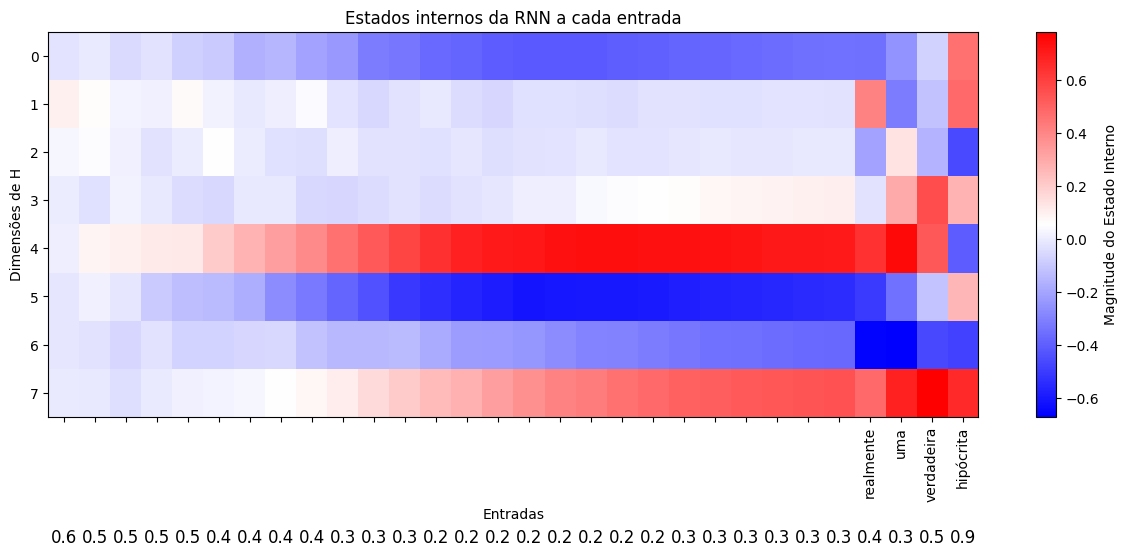

In [ ]:
def plot_internal_states(states, outputs, inputs):
    plt.figure(figsize=(15, 5))
    plt.imshow(states[0].T, aspect='auto', cmap='bwr')
    plt.colorbar(label='Magnitude do Estado Interno')
    plt.xlabel('Entradas')
    plt.ylabel('Dimensões de H')
    plt.title('Estados internos da RNN a cada entrada')

    # Marcar os inputs no eixo x
    plt.xticks(ticks=np.arange(len(inputs)), labels=inputs, rotation=90)

    for t in range(outputs.shape[0]):
        plt.text(t, 10, f'{outputs[t]:.1f}', ha='center', va='center', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=0.5))

    plt.show()

plot_internal_states(layer_output[0], model_outputs, tokenizer.sequences_to_texts(test_hate_data[30].reshape(-1, 1)))

Visualizar estados internos é uma tarefa complexa. Não é possível compreender exatamente como se comporta cada dimensão de um estado de uma rede já treinada, mas como estamos tratando de um problema binário é interessante visualizar a mudança nos estados a cada para inserida.

Podemos ver que ao ler a palavra "hipócrita" a rede passa a ter significativas mudanças no estado interno e assume uma saída positiva, pois considerando as palavras anteriores realmente ainda não era possível determinar como positivo ou negativo. Fica claro que a palavra se torna um elemento chave para a interpretação da rede.

No bloco abaixo temos uma caixa de entrada dinâmica onde podemos avaliar frases originais que não estão do dataset e visualizar o comportamento e saída da RNN ao processar a entrada.

No exemplo já inserido podemos ver que a palavra "safado" ao ocorrer antes já define um estado positivo e a "hipócrita" apenas a reforça.

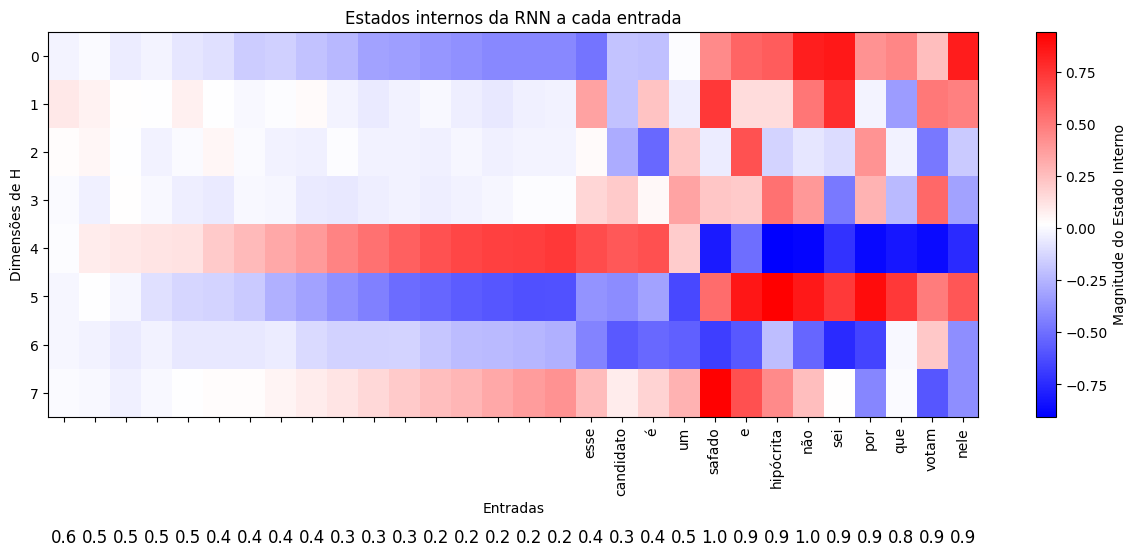

In [ ]:
# @title Insira algum texto de exemplo para ver a dinâmica dos estados internos
input = "Esse candidato é um safado e hipócrita, não sei por que votam nele" # @param {type:"string"}

s = str(input).lower()
table = str.maketrans({key: None for key in string.punctuation.replace("'", "")})
s = s.translate(table)
s = s.translate(str.maketrans({"'" : " "}))
input_tokens = word_tokenize(s)
input_tokenized = tokenizer.texts_to_sequences([input_tokens])
input_padded = pad_sequences(input_tokenized, maxlen=MAX_LEN)

layer_output = get_h_state(input_padded.reshape(1, -1))
model_outputs = get_output(layer_output[0][0])[0].reshape(30)
plot_internal_states(layer_output[0], model_outputs, tokenizer.sequences_to_texts(input_padded.reshape(-1, 1)))

Agora iremos treinar uma LSTM no mesmo problema em questão.
Usando Keras a única diferença é trocar a camada SimpleRNN por LSTM. Assim iremos criar uma camada LSTM com estado interno de tamanho 8.

In [ ]:
from keras.layers import LSTM


model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(train_word_index)+1,
                    output_dim=EMB_DIM,
                    input_length=MAX_LEN,
                    weights=[train_embedding_weights],
                    trainable=False))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.fit(train_hate_data, train_data['label'], epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
112/112 [==============================] - 5s 9ms/step - loss: 0.6411 - accuracy: 0.6172 - val_loss: 0.9026 - val_accuracy: 0.1931
Epoch 2/10
112/112 [==============================] - 1s 6ms/step - loss: 0.5513 - accuracy: 0.7363 - val_loss: 0.9680 - val_accuracy: 0.4018
Epoch 3/10
112/112 [==============================] - 1s 5ms/step - loss: 0.4507 - accuracy: 0.8114 - val_loss: 1.0100 - val_accuracy: 0.4609
Epoch 4/10
112/112 [==============================] - 1s 5ms/step - loss: 0.4008 - accuracy: 0.8354 - val_loss: 1.0376 - val_accuracy: 0.4743
Epoch 5/10
112/112 [==============================] - 1s 6ms/step - loss: 0.3738 - accuracy: 0.8451 - val_loss: 1.0801 - val_accuracy: 0.5033
Epoch 6/10
112/112 [==============================] - 1s 5ms/step - loss: 0.3563 - accuracy: 0.8502 - val_loss: 0.9644 - val_accuracy: 0.5580
Epoch 7/10
112/112 [==============================] - 1s 5ms/step - loss: 0.3402 - accuracy: 0.8599 - val_loss: 1.0217 - val_accuracy: 0.5123
Epoch 

A LSTM irá provavelmente obter um melhor resultado. Porém, para realmente conseguir um resultado superior o ideal é aumentar o número de épocas e o tamanho do estado interno para fazer com que a rede aprenda melhor sobre os dados.

**Exercício 3:** Tente alterar esses parâmetros de treino para alcançar melhores resultados.

**Exercício 4:** Para explorar melhor o comportamento das RNNs que tal tentar refazer o todo o processo com algum dos diferentes rótulos que o *dataset* fornece.


---
**Desafio:** Implemente uma arquitetura com múltiplas camadas para alcançar um desempenho superior. Para isso leia a documentação da ferramenta Sequential e tente adicionar mais camadas recorrentes ou Dense.

https://keras.io/guides/sequential_model/

# Referências
- Keras: https://keras.io
- RNN no Keras: https://keras.io/api/layers/recurrent_layers/simple_rnn/
- LSTM no Keras: https://keras.io/api/layers/recurrent_layers/lstm/
- Dataset de linguagem ofensiva: https://github.com/franciellevargas/MOL
